<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"> </td>
     <td style="background-color:transparent;"><a href="https://www.sidetrade.com/">
<img border="0" src="https://www.sidetrade.com/wp-content/uploads/22050384_10213210110060640_1095182809_o-300x117.png" width="60%"> </td>
  </tr>
</table> 
</div>

<center><h1>FAN revenue prediction challenge</h1></center>
<br/>
<center>Lucy Liu (CDS), Maria Teleczuk (CDS), Clément Chastagnol (Sidetrade),<br /> Gael Varoquaux (Inria, Parietal), Alex Gramfort (Inria, Parietal), Guillaume Lemaitre (Scikit-learn @ Inria Foundation)</center>

Predicting revenue using French Attribution Notices: [RAMP studio challenge](https://ramp.studio/problems/fan_revenue_prediction)

## Table of Contents

0. [Introduction](#Introduction)
1. [Data](#Data)
3. [Score metric](#Score-metric)
4. [Data exploration](#Data-exploration)
5. [Predictions](#Predictions)
6. [Record linkage](#Record-linkage)
7. [Submission structure](#Submission-structure)
8. [Local testing](#Local-testing-(before-submission))
9. [Submitting to RAMP studio](#Submitting-to-[ramp.studio](http://ramp.studio))
10. [More information](#More-information)

# Introduction

The objective of this challenge is to work with 'dirty data'. Most real data is dirty and the availability of high-quality, open-source ML and data analysis frameworks (such as [scikit-learn](https://scikit-learn.org/),
[pandas](https://pandas.pydata.org/)...) means that the next frontier for tooling and automation lies in preprocessing. This challenge aims to investigate methodologies to perform statistical analysis directly on the original dirty data.

There are two datasets in this challenge:

* `company_revenue_TRAIN.csv` - company revenue declarations.
* `award_notices_RAMP.csv` -  French Attribution Notices.

# Aim

The predictive aim of this challenge is to use `company_revenue_TRAIN.csv` and `award_notices_RAMP.csv` to predict the Revenue for each entry in the 'company financial data' dataset. It is advised that you use both datasets, as it improves the prediction (see [Score comparison](#Score-comparison)), but using only the `company_revenue_TRAIN.csv` dataset is also allowed.

# Data

## Company financial data

This dataset was built from an extract of the [National Institute of Statistics and Economic Studies (INSEE)](https://www.insee.fr/en/accueil) reference database of company revenue declarations from 2013 to 2018. Each row represents the declaration of one company for one year and the following information is provided in the columns:

* `Legal_ID` - the reconcilled legal ID of the company
* `Name` - the name of the company
* `Activity_code (APE)` - 'Activite Principale de l'Entreprise', the main activity of the company - more information in [English](https://www.startbusinessinfrance.com/code-ape) or in [French](https://www.service-public.fr/professionnels-entreprises/vosdroits/F33050)
* `Address` 
* `Zipcode`
* `City`
* `Revenue` - in Euros
* `Headcount`
* `Fiscal_year_end_date`
* `Fiscal_year_duration_in_months`
* `Year`

There are a few things to note:

* there are revenue declarations for the same company but different years
* there is a large reduction in entries for the years 2017 and 2018 due to the Loi Macron law in 2017
* the 'same company' can have several different entities, resulting in entries where the `Legal_ID` is different but the `Name`, `Address`, `City` and `Zipcode` are all the same.
* `Revenue` can be negative. A negative revenue may be due to cancelled orders from the previous fiscal year that was recorded in the current fiscal year.


## Award notices

Every French public organisation has to issue a call for tenders when buying supplies or services (above a minimum threshold). These are called public procurement contracts. Companies then compete anonymously on these contracts and when a bid is awarded, a notice has to be legally published by the public organization on the [BOAMP](https://www.boamp.fr/) (historical data is hosted by the [DILA](https://www.dila.premier-ministre.gouv.fr/)). These are called French Attribution Notices (FAN). About 25% of awards are actually electronically published.

Each contract can be divided into a maximum of 5 lots and the same company can win >1 lot of a contract. The award notices dataset comprises award notices from 2017 and 2018. Each row refers to one lot and there can be up to 5 lots referring to the same contract. The following information is provided for each lot:

* `ID_call` - ID of the award notice
* `Publication_date` of the award notice
* `End_of_call_date` of the award notice
* `Departments_of_publication` - the department code(s) of the award notice
* `Department_of_provision` - the department code(s) where the contract works/goods/services were provided 
* `Call_summary` - summary of the award notice
* `Call_title` - title of the award notice
* `Complete_call_description` - description of the award notice
* `Total_amount` - total amount of the contract, from all lots, in euros
* `CPV_classes` - Common Procurement Vocabulary (CPV), a classification system for public procurement used to describe the subject of procurement contracts (more information can be found [here](https://simap.ted.europa.eu/cpv))
Columns providing details about the company issuing the contract:
* `Buyer_name` 
* `Buyer_address`
* `Buyer_zipcode`
* `Buyer_city`
* `Buyer_email`
* `Buyer_URL`

* `Contract_awarded` - whether or not the contact was awarded

Columns providing details about the winner of each lot:

* `ID` - unique lot ID 
* `awarded` - whether or not the contact was awarded
* `description` - description of the lot
* `incumbent_name` - name of the lot winnter
* `incumbent_address` - address of the lot winner
* `incumbent_zipcode` - zipcode of the lot winner
* `incumbent_city` - city of the lot winner
* `incumbent_country` - country of the lot winner
* `number_of_received_bids` - number of bids this lot received
* `amount` - amount of the lot in euros

**Important notes**

Both data sets are very dirty. There is a lot of missing data and the column descriptions provided above are a guide only. Further, the award notices dataset is much smaller than the company revenue declarations dataset. Therefore, it is expected that many companies in the company revenue declarations dataset are not present in the award notices dataset.

## Training and test

The company revenue training dataset has been split into 'training' and 'test' subsets. The shapes are:

* training: (1 495 948, 11)
* test: (520 966, 11)

Your model will be tested on a completely separate company revenue dataset stored on the RAMP server. This dataset has a shape of (702 181, 11). This test dataset will also be dirty but we can guarantee that the following columns will (only) be of numerical data type:

* `Legal_ID`
* `Headcount`
* `Fiscal_year_duration_in_months`
* `Year`

# Score metric

A unique score is used:

$$score =  |max(5,log_{10}(max(1,y\_true))) - max(5,log_{10}(max(1,y\_pred)))| $$

Score interpretation:

* A lower score is better
* Any `y_true` or `y_pred` value less than 1 is 'taken' as 1
* If both the `y_true` and `y_pred` are less than 100 000, the score would be 0.
* The score is the same regardless of the order of `y_true` and `y_pred` in the equation.
* If the difference in raw `y_true` and `y_pred` values is the same, the score is greater for smaller magnitudes of `y_true` and `y_pred`.

# Data exploration

In [38]:
%matplotlib inline
import imp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
from problem import get_train_data

## Company financial data

In [39]:
# from problem import get_train_data
# X_df, y_array = get_train_data()

# nb_rows_for_analysis = 150000
# X_df['target'] = y_array
# df = X_df.sample(n=nb_rows_for_analysis).reset_index(drop=True, inplace=False)
# df.drop('target', 1).to_pickle("./df.pkl")
# df['target'].to_pickle("./y_array.pkl")

X_df = pd.read_pickle("./df.pkl")
y_array = pd.read_pickle("./y_array.pkl").values

In [3]:
X_df.head(3)

,Legal_ID,Name,Activity_code (APE),Address,Zipcode,City,Headcount,Fiscal_year_end_date,Fiscal_year_duration_in_months,Year
0,508099108,LA ROSEE,4941B,142 RUE DIDEROT,93500.0,PANTIN,NaN,2014-06-30,12.0,2014.0
1,423492271,BELGO MALIENNE PARIS,4511Z,47 BOULEVARD DE COURCELLES,75008.0,LA COURNEUVE,NaN,2014-12-31,12.0,2014.0
2,433481843,PULDEM,4942Z,5 AVENUE DU BOIS VERT,31120.0,PORTET SUR GARONNE,36.0,2013-12-31,12.0,2013.0


In [4]:
X_df['Fiscal_year_end_date'] = pd.to_datetime(X_df['Fiscal_year_end_date'], format='%Y-%m-%d')

In [5]:
X_df.shape

(150000, 10)

In [6]:
# proportion of NaN values
X_df.isna().sum() / X_df.shape[0]

Legal_ID                          0.000000
Name                              0.000000
Activity_code (APE)               0.012553
Address                           0.174453
Zipcode                           0.167013
City                              0.000253
Headcount                         0.636507
Fiscal_year_end_date              0.000000
Fiscal_year_duration_in_months    0.000000
Year                              0.000000
dtype: float64

In [7]:
# number of unique values
X_df.nunique()

Legal_ID                          133755
Name                              130352
Activity_code (APE)                  775
Address                            89131
Zipcode                             6328
City                               17331
Headcount                            741
Fiscal_year_end_date                 114
Fiscal_year_duration_in_months         1
Year                                   6
dtype: int64

In [8]:
X_df.dtypes

Legal_ID                                   int64
Name                                      object
Activity_code (APE)                       object
Address                                   object
Zipcode                                  float64
City                                      object
Headcount                                float64
Fiscal_year_end_date              datetime64[ns]
Fiscal_year_duration_in_months           float64
Year                                     float64
dtype: object

In [9]:
X_df.describe(include='all')

,Legal_ID,Name,Activity_code (APE),Address,Zipcode,City,Headcount,Fiscal_year_end_date,Fiscal_year_duration_in_months,Year
count,1.500000e+05,150000,148117,123832,124948.000000,149962,54524.000000,150000,150000.0,150000.000000
unique,NaN,130352,775,89131,NaN,17331,NaN,114,NaN,NaN
top,NaN,L'ATELIER,6420Z,LE BOURG,NaN,PARIS,NaN,2013-12-31 00:00:00,NaN,NaN
freq,NaN,11,7900,225,NaN,13747,NaN,24852,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-12 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 00:00:00,NaN,NaN
mean,5.059926e+08,NaN,NaN,NaN,54601.399238,NaN,78.466437,NaN,12.0,2014.474353
std,1.413368e+08,NaN,NaN,NaN,27545.476643,NaN,5119.369573,NaN,0.0,1.247581
min,6.066160e+05,NaN,NaN,NaN,6.000000,NaN,-4.000000,NaN,12.0,2013.000000
25%,4.148026e+08,NaN,NaN,NaN,31830.000000,NaN,1.000000,NaN,12.0,2013.000000


### Distribution of Revenue

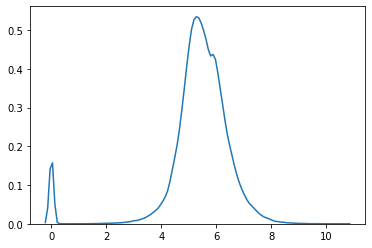

In [10]:
logRev = np.log10(np.clip(y_array, a_min=1, a_max=None))
seaborn.kdeplot(logRev)

## Award notices

This dataset is present in the `data/` directory and is added by default to **all** submissions when submitting to RAMP studio. When testing your submission locally however, it is important to copy this file into the submission directory of the submission you wish to test.

For example, the starting kit submission directory (`submissions/starting_kit`) contains a copy of this dataset as it is required for RAMP to work locally. You will not need to upload this data file when you are making a submission. See for more information.

In [11]:
award = pd.read_csv('data/award_notices_RAMP.csv.zip', compression='zip')
award.head(3)

/Users/emmademarecaux/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CallID,Publication_date,End_of_call_date,Departments_of_publication,Departments_of_provision,Call_summary,Call_title,Complete_call_description,Total_amount,CPV_classes,...,ID,awarded,description,incumbent_name,incumbent_address,incumbent_zipcode,incumbent_city,incumbent_country,number_of_received_bids,amount
0,16-119770,2016-08-11 00:00:00,2016-09-20,13,NaN,mission de maitrise d'oeuvre relative aux trav...,MISSION DE MAITRISE D'OEUVRE RELATIVE AUX TRAV...,MISSION DE MAITRISE D'OEUVRE RELATIVE AUX TRAV...,NaN,71000000,...,NaN,Yes,NaN,AI PROJECT,"11, avenue de la Capelette",13010,Marseille,FR,13.0,83200.0
1,15-46335,2015-03-27 00:00:00,2015-04-25,85,85,fourniture de réactifs immunosérologiques pour...,NaN,Fourniture de réactifs immunosérologiques pour...,NaN,33696200 33696500,...,1,Yes,Kit pour recherche d'anticorps anti-IBR sur sé...,ID-VET,310 rue Louis Pasteur,34790,Grabels,FR,2.0,NaN
2,15-46335,2015-03-27 00:00:00,2015-04-25,85,85,fourniture de réactifs immunosérologiques pour...,NaN,Fourniture de réactifs immunosérologiques pour...,NaN,33696200 33696500,...,2,Yes,Kit pour recherche d'anticorps anti-IBR sur mé...,IDEXX MONTPELLIER SAS,323 RUE DE LA GALERA,34090,MONTPELLIER,FR,2.0,NaN


In [12]:
award.shape

(304098, 28)

In [13]:
award.dtypes

CallID                         object
Publication_date               object
End_of_call_date               object
Departments_of_publication     object
Departments_of_provision       object
Call_summary                   object
Call_title                     object
Complete_call_description      object
Total_amount                  float64
CPV_classes                    object
Buyer_name                     object
Buyer_address                  object
Buyer_zipcode                  object
Buyer_city                     object
Buyer_email                    object
Buyer_URL                      object
Contract_awarded               object
Lot                             int64
ID                             object
awarded                        object
description                    object
incumbent_name                 object
incumbent_address              object
incumbent_zipcode              object
incumbent_city                 object
incumbent_country              object
number_of_re

In [14]:
award.describe()

,Total_amount,Lot,number_of_received_bids,amount
count,1.121260e+05,304098.000000,220936.000000,2.159540e+05
mean,5.177948e+08,2.073213,4.606900,1.145206e+08
std,6.712391e+10,1.293831,7.982825,2.288319e+10
min,9.900000e-05,1.000000,0.000000,0.000000e+00
25%,1.967891e+05,1.000000,2.000000,3.240000e+04
50%,4.821163e+05,2.000000,3.000000,1.159775e+05
75%,1.568197e+06,3.000000,5.000000,3.674995e+05
max,1.000000e+13,5.000000,727.000000,1.000000e+13


In [15]:
# proportion of NA values
award.isna().sum() / award.shape[0]

CallID                        0.000016
Publication_date              0.000016
End_of_call_date              0.000510
Departments_of_publication    0.000016
Departments_of_provision      0.674611
Call_summary                  0.000016
Call_title                    0.346484
Complete_call_description     0.005426
Total_amount                  0.631283
CPV_classes                   0.082602
Buyer_name                    0.000016
Buyer_address                 0.017484
Buyer_zipcode                 0.024084
Buyer_city                    0.000016
Buyer_email                   0.163766
Buyer_URL                     0.211047
Contract_awarded              0.000016
Lot                           0.000000
ID                            0.271015
awarded                       0.034907
description                   0.512683
incumbent_name                0.034943
incumbent_address             0.140126
incumbent_zipcode             0.103414
incumbent_city                0.061280
incumbent_country        

# Predictions

## Company revenue only

First, let's predict using only the `comp` dataset:

1. Create a transformer that deals with missing values:

In [16]:
X_df.dtypes

Legal_ID                                   int64
Name                                      object
Activity_code (APE)                       object
Address                                   object
Zipcode                                  float64
City                                      object
Headcount                                float64
Fiscal_year_end_date              datetime64[ns]
Fiscal_year_duration_in_months           float64
Year                                     float64
dtype: object

The feature `Fiscal_year_duration_in_months` is the same for all the observations, therefore we will not use it for our prediction model.

In [17]:
X_df['Fiscal_year_duration_in_months'].unique()

array([12.])

In [18]:
# list of numerical columns
num_cols = ['Legal_ID', 'Year', 'Headcount']

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median'))
])

2. Create a transformer to split `Fiscal_year_end_date` into separate year, month, day columns:

In [20]:
from sklearn.preprocessing import FunctionTransformer

def process_date(X):
    date = pd.to_datetime(X['Fiscal_year_end_date'], format='%Y-%m-%d')
    return np.c_[date.dt.month, date.dt.day]

date_transformer = FunctionTransformer(process_date, validate=False)

3. Process the `Activity_code (APE)` column. At the moment the Scikit learn `OrdinalEncoder()` does not have a `handle_unknown` argument. This means that it would not be able to handle any values in `Activity_code (APE)` which appear in 'train' but do not appear in 'test'. Here we will simply get around this by using the first 4 characters of `APE`, which are always numbers. The first 2 numbers give the broad category the companies activities fall under (e.g. 'AGRICULTURE'). This column is then converted to numeric data type, so missing values can be dealt with by using the median value (with `SimpleImputer()`).

In [21]:
def process_APE(X):
    APE = X['Activity_code (APE)'].str[:-1]
    return pd.to_numeric(APE, errors='coerce').values[:, np.newaxis] 

APE_transformer = FunctionTransformer(process_APE, validate=False)

4. Clean the `Zipcode` column:

In [22]:
from recordlinkage.preprocessing import clean

big_city_zip = {
    'caen': 14000, 'dijon': 21000, 'strasbourg': 67000, 
    'nantes': 44000, 'amiens': 80000,'orleans': 45000,
    'montpellier': 34000, 'ajaccio': 20000, 'marseille': 13000,
    'limoges': 87000, 'rennes': 35000, 'besancon': 25000,
    'chalonsenchampagne': 51000, 'metz': 57000, 'lille': 59000,
    'bordeaux': 33000, 'rouen': 76000, 'clermontferrand': 63000,
    'toulouse': 31000, 'paris': 75000, 'lyon': 69000, 'poitiers': 86000
}

def remove_cedex(x):
    return str(x).replace('cedex', '').replace('ceddex', '').replace(
        'ceedex', '').replace('cededx', '').replace('cadex', '').replace(
        'cdedex', '').replace('vedex', '').replace('crdex', '').replace(
        'dedex', '').replace('edex', '').replace('cdex', '').replace(
        'cedx', '').replace('cdx', '')

# Cleaning 'City' feature.
def deep_clean(X, feature='City'):
    return clean(X[feature]).str.replace('[^\w]','').str.replace('[0-9]','').apply(lambda x: remove_cedex(x))

# Creating a dictionnary with the zipcode of each city in order to have uniform zipcodes accross cities
# and to fill some NaN values.
X_clean = X_df[['City', 'Zipcode']].copy()
X_clean['City_clean'] = deep_clean(X_clean, 'City')
X_clean['Zipcode'] = pd.to_numeric(X_clean['Zipcode'], errors='coerce')
city_zip = X_clean[~X_clean['City_clean'].isin(big_city_zip.keys())][['City_clean', 'Zipcode']].dropna()

aw_clean = award[['incumbent_city', 'incumbent_zipcode']].copy()
aw_clean['City_clean'] = deep_clean(aw_clean, 'incumbent_city')
aw_clean['Zipcode'] = pd.to_numeric(aw_clean['incumbent_zipcode'], errors='coerce')
city_zip_aw = aw_clean[~aw_clean['City_clean'].isin(big_city_zip.keys())][['City_clean', 'Zipcode']].dropna()

# Zipcodes of all the cities.
other_city_zip = pd.concat([city_zip, city_zip_aw[~city_zip_aw['City_clean'].isin(city_zip['City_clean'])]])
other_city_zip = other_city_zip.groupby('City_clean').agg(lambda x: x.value_counts().index[0])['Zipcode'].to_dict()
all_city_zip = {**other_city_zip, **big_city_zip}

In [23]:
# Filling zipcode values
def fill_zipcode(row, all_city_zip=all_city_zip):
    if row['City_clean'] in all_city_zip.keys():
        return all_city_zip[row['City_clean']]
    else:
        return row['Zipcode']

def clean_city_zipcode(X, all_city_zip=all_city_zip):
    X_clean = X[['City', 'Zipcode']].copy()
    # City cleaning 
    X_clean['City_clean'] = deep_clean(X_clean, 'City')
    # Zipcode cleaning
    X_clean.loc[pd.notnull(X_clean['City_clean']), 'Zipcode'] = X_clean.loc[
        pd.notnull(X_clean['City_clean']), ['Zipcode', 'City_clean']
    ].apply(lambda row: fill_zipcode(row, all_city_zip), axis=1)
    return X_clean[['City_clean', 'Zipcode']]

# Creating a new feature using 'City' and 'Zipcode' providing the size and the type of a city.
def city_size(row, big_city_zip=big_city_zip):
    big_cities = ['paris', 'marseille', 'toulouse', 'lyon']
    city, zipcode = row["City_clean"], row["Zipcode"]
    if (pd.notnull(city)) and (city in big_city_zip.keys()):
        if city in big_cities:
            return city
        else:
            return 'prefecture'
    else:
        if pd.notnull(zipcode):
            if str(zipcode)[:2] in ['75', '77', '78', '91', '92', '93', '94', '95']:
                return 'ile_france'
            elif zipcode >= 97000:
                return 'overseas'
            elif zipcode % 1000 == 0:
                return 'big_city'
            elif zipcode % 100 == 0:
                return 'medium_city'
            elif zipcode % 10 == 0:
                return 'small_city'
            else:
                return 'very_small_city'
        else:
            return 'other'

In [24]:
def process_zipcode(X, all_city_zip=all_city_zip):
    zipcode_nums = pd.to_numeric(clean_city_zipcode(X, all_city_zip)['Zipcode'], errors='coerce')
    return zipcode_nums.values[:, np.newaxis]

zipcode_transformer = FunctionTransformer(process_zipcode, validate=False)

def process_city(X, big_city_zip=big_city_zip, all_city_zip=all_city_zip):
    X_clean = clean_city_zipcode(X, all_city_zip)
    X_clean['Zipcode'] = pd.to_numeric(X_clean['Zipcode'], errors='coerce')
    return X_clean.apply(lambda row: city_size(row, big_city_zip), axis=1).values[:, np.newaxis]

city_transformer = FunctionTransformer(process_city, validate=False)

## Merge

Now let us predict using a naive merge of `award` and `comp` datasets.

The merge will only use the name of the company and the year. To aid the merging we will convert preprocess the name of the companies.

In [25]:
# Processing the award dataframe
award.dropna(subset=['awarded','Contract_awarded','incumbent_name'], inplace=True)
award.drop(['awarded','Contract_awarded'], axis=1, inplace=True)
award['Year'] = pd.to_datetime(award['Publication_date'], format='%Y-%m-%d').dt.year
award.drop(['Publication_date'], axis=1, inplace=True)
award['name'] = deep_clean(award, 'incumbent_name')
award_num = award[['Year', 'Total_amount', 'Lot', 'number_of_received_bids', 'amount']]
award_num = award_num.apply(pd.to_numeric, errors='coerce').fillna(award_num.median()) 
award_sum = award.groupby(['name', 'Year'])[
    ['Total_amount', 'Lot', 'number_of_received_bids', 'amount']].sum()
award_count = award.groupby(['name', 'Year'])[
    ['Total_amount', 'Lot', 'number_of_received_bids', 'amount']].count()
award_count.columns = award_count.columns + '_c'
award_features = pd.concat([award_sum, award_count], axis=1).reset_index()

For each company, extract 8 features:

* the number of `Total_amount`
* the total sum of `Total_amount`
* the number of `Lot`
* the total sum of `Lot`
* the number of `number_of_received_bids`
* the total sum of `number_of_received_bids`
* the number of `amount`
* the total sum of `amount`

In [26]:
award_features.tail(3)

,name,Year,Total_amount,Lot,number_of_received_bids,amount,Total_amount_c,Lot_c,number_of_received_bids_c,amount_c
154390,zwickfrance,2017,664280.0,6,7.0,289150.0,2,3,3,3
154391,zymovert,2016,0.0,2,4.0,200000.0,0,1,1,1
154392,zymovert,2017,2753000.0,1,3.0,2600000.0,1,1,1,1


Next we will perform a merge of `X_df` and `award_features`. 

Be careful in this step to ensure that the **order** of `X_df` is not changed.

In [27]:
def merge(X):
    X['Name'] = deep_clean(X, 'Name')
    df = pd.merge(X, award_features, left_on=['Name', 'Year'], right_on=['name', 'Year'], how='left')
    return df[['Total_amount', 'Lot', 'number_of_received_bids', 'amount',
               'Total_amount_c', 'Lot_c', 'number_of_received_bids_c', 'amount_c']]

merge_transformer = FunctionTransformer(merge, validate=False)

Finally the full pipeline is assembled. 

* for missing values in numerical columns, the 'median' is used.
* the date column `Fiscal_year_end_date` is transformed into separated year month and day columns.
* `Activity_code (APE)`, `Zipcode` and `City` are dealt with as described above.
*  `Name` and `Year` are used to merge X_df and award_features.
* the columns `Address` and `Fiscal_year_duration_in_months` are all dropped.

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

date_cols = ['Fiscal_year_end_date']
num_cols = ['Legal_ID', 'Year', 'Headcount']
APE_cols = ['Activity_code (APE)']
zipcode_cols = ['Zipcode', 'City']
city_cols = ['Zipcode', 'City']
merge_cols = ['Name', 'Year']
drop_cols = ['Address', 'Fiscal_year_duration_in_months']

preprocessor_comp = ColumnTransformer(
    transformers=[
        ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median')), date_cols),
        ('num', numeric_transformer, num_cols),
        ('APE', make_pipeline(APE_transformer, SimpleImputer(strategy='median')), APE_cols),
        ('zipcode', make_pipeline(zipcode_transformer, SimpleImputer(strategy='median')), zipcode_cols),
        ('city', make_pipeline(city_transformer, SimpleImputer(strategy='most_frequent'), OrdinalEncoder()), city_cols),
        ('merge', make_pipeline(merge_transformer, SimpleImputer(strategy='median')), merge_cols),
        ('drop cols', 'drop', drop_cols),
    ])

In [29]:
# make sure it works
preprocessor_comp.fit_transform(X_df)

array([[6.00000000e+00, 3.00000000e+01, 5.08099108e+08, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.20000000e+01, 3.10000000e+01, 4.23492271e+08, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.20000000e+01, 3.10000000e+01, 4.33481843e+08, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [3.00000000e+00, 3.10000000e+01, 4.03759012e+08, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.00000000e+00, 3.00000000e+01, 5.08198512e+08, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.20000000e+01, 3.10000000e+01, 7.51844135e+08, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

We will use a Gradient Boosting Regressor model.

Before we can test our model, we need to define our unique scoring function:

In [30]:
from sklearn.metrics import make_scorer

def loss(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    true = np.maximum(5., np.log10(np.maximum(1., y_true)))
    pred = np.maximum(5., np.log10(np.maximum(1., y_pred)))
    
    loss = np.mean(np.abs(true - pred))
    
    return loss
    
fan_loss = make_scorer(loss, greater_is_better=False)

Now we can test our model. Note that we use `GroupShuffleSplit` using `Legal_ID` as the group so that the same company ('Legal_ID') only appears in either 'train' or 'test' but does not appear both in 'train' **and** 'test'.

This reflects the same conditions of this challenge where, the private 'test' data (on RAMP) does not contain any company that also appears in the public 'train' dataset you have access to. This is because `Revenue` for the same company is often very similar.

First, we apply a grid search algorithm to find the best parameters.

In [33]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

reg = GradientBoostingRegressor(loss='lad')

clf = Pipeline(steps=[
    ('preprocessing', preprocessor_comp),
    ('classifier', reg)])

# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(20, 80, name='n_estimators'),
          Integer(20, 60, name='max_depth'),
          Real(10**-2, 10**0, "log-uniform", name='learning_rate'),
          Integer(100, 400, name='min_samples_split'),
          Integer(100, 400, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(clf, X_df, y_array, cv=3, scoring=fan_loss, groups=X_df['Legal_ID'], n_jobs=-1))

In [35]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- n_estimators=%d
- learning_rate=%.6f
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best score: 0.3118

Best parameters:
- max_depth=50
- n_estimators=60
- learning_rate=0.094
- min_samples_split=400
- min_samples_leaf=100

In [36]:
regressor = GradientBoostingRegressor(
    n_estimators=60, max_depth=50, learning_rate=0.094, 
    min_samples_split=400, min_samples_leaf=100, loss='lad')

In [37]:
%%time
from sklearn.model_selection import GroupShuffleSplit

clf = Pipeline(steps=[
    ('preprocessing', preprocessor_comp),
    ('classifier', regressor)])

cv = GroupShuffleSplit(n_splits=8, test_size=0.25)

scores_Xdf = -cross_val_score(clf, X_df, y_array, cv=cv, scoring=fan_loss, groups=X_df['Legal_ID'], n_jobs=2)

print("mean: %e (+/- %e)" % (scores_Xdf.mean(), scores_Xdf.std()))

mean: 3.151130e-01 (+/- 1.108113e-03)


This example is implemented in RAMP within the files in the folder `submissions/gradient_boosting`. 

The transformation steps above are implemented in the file `submissions/gradient_boosting/feature_extractor.py` (a copy of this file is shown below). This file needs to define a class called `FeatureExtractor` which requires a `fit()` and `transform()` function. The `fit()` function takes both `X_df` and `y_array` as parameters, meaning that you are able to engineer new features using `y_array` (e.g. target encoding). The `transform()` function only takes `X_df`. We only use the `transform()` function in our simple example below.

Note that the `award` dataset is being read in from the submission folder (`submissions/gradient_boosting`). This means that when testing locally, each submission folder should contain a copy of the award dataset `award_notices_RAMP.csv`.

A baseline was implemented in the folder `submissions/starting_kit`.

## Local testing

First, ensure that `ramp-worflow` is installed (see the [github repo](https://github.com/paris-saclay-cds/ramp-workflow) for installation instructions). 

Now you can use `ramp_test_submission`. This command will test on files in [`submissions/starting_kit`](/submissions/starting_kit) by default. To specify testing on a different folder use the flag `--submission`. For example to run the test on `submissions/gradient_boosting` use: `ramp_test_submission --submission gradient_boosting`.